# Epeak_Eiso_cosmology.ipynb
We have searched for a $E_\text{peak}$-$E_\text{iso}$ fit in [Epeak_Eiso_correlation.ipynb](https://github.com/joanalnu/OAB-INAF/blob/main/Epeak_Eiso_correlation.ipynb) and computed $E_\text{iso}$ from respective fluences $S$ in dependency of cosmology. In this notebook, we employ that to constrain the cosmological parameters, searching for $E_\text{peak}$-$E_\text{iso}$ fit with less scatter (i.e. shorter point-fit distances), indicating the 'best cosmology.'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

In [2]:
# read data
df = pd.read_csv('table.csv')

Epeak = np.log10(df['Epeak'])
Epeak_err = np.log10(df['Epeak_err'])
z = df['z']
S = df['Fluence']  # ergs/cm2
S_err = df['Fluence_err']


# Convert H0 to cgs units: H0 [s^-1] = H0 [km/s/Mpc] * (km/Mpc to 1/s conversion)
# 1 Mpc = 3.086e24 cm, so H0_cgs = H0_kmsMpc * 1e5 / 3.086e24
H0_cgs = 70.0 * 1e5 / 3.086e24  # s^-1
c = 29979245800  # cm/s
Om_default = 0.3
Ode_default = 0.7
c = 2.99792458e10  # cm/s

def luminosity_distance(redshift, Ho=H0_cgs, O_m=Om_default, O_DE=Ode_default):
    """
    Calculate luminosity distance for given redshift(s) and cosmological parameters.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    Ho : float
        Hubble constant in cgs units (s^-1)
    O_m : float
        Matter density parameter
    O_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Luminosity distance in cm
    """

    def luminosity_distance_single(z, Ho=Ho, O_m=O_m, O_DE=O_DE):
        def integrand(z_prime):
            return 1.0 / np.sqrt(O_m * (1 + z_prime)**3 + O_DE)

        # Create redshift sample array
        z_array = np.linspace(0, z, num=1000)

        # Evaluate integrand on array
        y_values = integrand(z_array)

        # Compute definite integral from 0 to z
        integral = cumulative_trapezoid(y_values, z_array, initial=0)[-1]

        # Compute luminosity distance
        return (c * (1 + z) / Ho) * integral

    # Handle scalar and array inputs
    if np.isscalar(redshift):
        return luminosity_distance_single(redshift, Ho, O_m, O_DE)
    else:
        return np.array([luminosity_distance_single(z_i, Ho, O_m, O_DE) for z_i in redshift])

def curved_luminosity_distance(redshift, Ho=H0_cgs, O_m=Om_default, O_DE=Ode_default):
    """
    As luminosity_distance(), this function calculated the luminosity distance for given redshift(s) and cosmological parameters. However, this function does not assume a flat LambdaCDM model and instead uses Ok = 1.0-Ode-Om.
    :param redshift: float or array; Redshift value(s)
    :param Ho: hubble constant in cgs units (s^-1)
    :param O_m: matter density parameter
    :param O_DE: dark energy density parameter
    :return: float or array; luminosity distance in cm
    """

    def luminosity_distance_single(z, Ho=Ho, O_k=(1.0-O_m-O_DE), O_m=O_m, O_DE=O_DE):
        def integrand(z_prime):
            return 1.0/np.sqrt(O_m * (1 + z_prime)**3 + O_DE + O_k*(1+z_prime)**2)

        z_array = np.linspace(0,z,num=1000)
        y_values = integrand(z_array)
        integral = cumulative_trapezoid(y_values, z_array, initial=0)[-1]
        constants = (c * (1+z)/Ho)
        return constants*integral

    O_k = 1.0 - O_DE - O_m
    if np.isscalar(redshift):
        return luminosity_distance_single(redshift, Ho, O_k, O_m, O_DE)
    else:
        return np.array([luminosity_distance_single(z_i, Ho, O_k, O_m, O_DE) for z_i in redshift])

def isotropic_equivalent_energy(redshift, fluence, H0=H0_cgs, Omega_m=Om_default, Omega_DE=Ode_default):
    """
    Calculate the isotropic equivalent energy.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    fluence : float or array
        Observed fluence (should be in erg/cm^2)
    H0 : float
        Hubble constant in cgs units (s^-1)
    Omega_m : float
        Matter density parameter
    Omega_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Log10 of isotropic equivalent energy
    """
    d_L = curved_luminosity_distance(redshift, H0_cgs, Omega_m, Omega_DE)
    numerator = 4.0 * np.pi * (d_L ** 2) * fluence
    return np.log10(numerator / (1 + redshift))

def measure_distances(a, b, x, y):
    """
    Measures the distance between a point p = (x,y) and a line of best fit y=ax+b.
    :param p: coordinates of the point
    :param a: slope of the fit
    :param b: y-axis cut of the fit
    :return: scalar for the distance
    """
    # for the line point we use x0=0 and thus y0=b
    numerator = abs(a*x -y +b)
    denominator = np.sqrt(1 + (a ** 2))
    return numerator / denominator

def GoF(m,k,x,y):
    """
    Goodness of fit following the chi-squared formula
    :param m: slope
    :param k: y-axis cut
    :param x: x-values
    :param y: y-values
    :return: chi-squared value
    """
    model = m*x + k
    chi_squared = np.sum((y-model)**2)
    return chi_squared

In [3]:
# Define cosmological parameter grids
Om = np.linspace(0.0,2.0,25)
Ode = np.linspace(0.0,2.0,25)
k = np.linspace(-25.,-20.,25) # from the previous scatter plot, we can infer that the y-axis cut is around -25 and -20
m = np.linspace(0.0,1.0,25) # the slope must be positive

data = np.zeros([len(Om), len(Ode), len(df['Eiso'])])
#fig, ax = plt.subplots(len(Om), len(Ode), figsize=(15,15))
for i in range(len(Om)):
    for j in range(len(Ode)):
        try:
            isotropic_model = isotropic_equivalent_energy(z,S,H0_cgs,Om[i],Ode[j])

            # check for NaN or inf values
            if np.any(~np.isfinite(isotropic_model)):
                data[i,j,:] = np.inf # instead of NaN which creates problems when finding minimum with argmin
                continue

            G = np.zeros([len(m), len(k)]) # G[i,j] corresponds to m[i], k[j]
            for mu in range(len(m)):
                for nu in range(len(k)):
                    G[mu,nu] = GoF(m[mu], k[nu], x=isotropic_model, y=Epeak)

            # extract best fit parameters
            best_fit = np.argmin(G)
            m_index, k_index = np.unravel_index(best_fit, G.shape)
            m_fit, k_fit = m[m_index], k[k_index]
            data[i,j,:] = measure_distances(m_fit, k_fit, isotropic_model, Epeak)
            print(f'{i} {j}\tOm={Om[i]:.3f}, Ode={Ode[j]:.3f}, m_fit={m_fit:.3f}, k_fit={k_fit:.3f}')

            #ax[i, j].scatter(isotropic_model, Epeak, s=1)
            #ax[i, j].plot(isotropic_model, m_fit * isotropic_model + k_fit, c='r')

        except Exception as e:
            print(f'Error at Om={Om[i]:.3f}, Ode={Ode[j]:.3f}: {e}')
            data[i,j,:] = np.inf # mark as invalid

np.save('distances.npy', data)

00	Om=0.000, Ode=0.000, m_fit=0.458, k_fit=-21.667
01	Om=0.000, Ode=0.083, m_fit=0.458, k_fit=-21.667
02	Om=0.000, Ode=0.167, m_fit=0.458, k_fit=-21.667
03	Om=0.000, Ode=0.250, m_fit=0.458, k_fit=-21.667
04	Om=0.000, Ode=0.333, m_fit=0.458, k_fit=-21.667
05	Om=0.000, Ode=0.417, m_fit=0.458, k_fit=-21.667
06	Om=0.000, Ode=0.500, m_fit=0.458, k_fit=-21.667
07	Om=0.000, Ode=0.583, m_fit=0.458, k_fit=-21.667
08	Om=0.000, Ode=0.667, m_fit=0.458, k_fit=-21.667
09	Om=0.000, Ode=0.750, m_fit=0.458, k_fit=-21.667
010	Om=0.000, Ode=0.833, m_fit=0.458, k_fit=-21.667
011	Om=0.000, Ode=0.917, m_fit=0.500, k_fit=-23.958
012	Om=0.000, Ode=1.000, m_fit=0.458, k_fit=-21.875
10	Om=0.083, Ode=0.000, m_fit=0.500, k_fit=-23.750
11	Om=0.083, Ode=0.083, m_fit=0.500, k_fit=-23.750
12	Om=0.083, Ode=0.167, m_fit=0.458, k_fit=-21.667


/var/folders/lq/7_q5kjhn1pzgzvpl0fk8y5mc0000gp/T/ipykernel_10483/1140892461.py:74: RuntimeWarning: invalid value encountered in sqrt
  return 1.0/np.sqrt(O_m * (1 + z_prime)**3 + O_DE + O_k*(1+z_prime)**2)


13	Om=0.083, Ode=0.250, m_fit=0.458, k_fit=-21.667
14	Om=0.083, Ode=0.333, m_fit=0.458, k_fit=-21.667
15	Om=0.083, Ode=0.417, m_fit=0.458, k_fit=-21.667
16	Om=0.083, Ode=0.500, m_fit=0.458, k_fit=-21.667
17	Om=0.083, Ode=0.583, m_fit=0.458, k_fit=-21.667
18	Om=0.083, Ode=0.667, m_fit=0.458, k_fit=-21.667
19	Om=0.083, Ode=0.750, m_fit=0.458, k_fit=-21.667
110	Om=0.083, Ode=0.833, m_fit=0.458, k_fit=-21.667
111	Om=0.083, Ode=0.917, m_fit=0.458, k_fit=-21.667
112	Om=0.083, Ode=1.000, m_fit=0.458, k_fit=-21.667
113	Om=0.083, Ode=1.083, m_fit=0.500, k_fit=-23.958
114	Om=0.083, Ode=1.167, m_fit=0.458, k_fit=-21.875
115	Om=0.083, Ode=1.250, m_fit=0.458, k_fit=-21.875
20	Om=0.167, Ode=0.000, m_fit=0.500, k_fit=-23.750
21	Om=0.167, Ode=0.083, m_fit=0.500, k_fit=-23.750
22	Om=0.167, Ode=0.167, m_fit=0.500, k_fit=-23.750
23	Om=0.167, Ode=0.250, m_fit=0.458, k_fit=-21.667
24	Om=0.167, Ode=0.333, m_fit=0.458, k_fit=-21.667
25	Om=0.167, Ode=0.417, m_fit=0.458, k_fit=-21.667
26	Om=0.167, Ode=0.500, m

/var/folders/lq/7_q5kjhn1pzgzvpl0fk8y5mc0000gp/T/ipykernel_10483/1140892461.py:74: RuntimeWarning: divide by zero encountered in divide
  return 1.0/np.sqrt(O_m * (1 + z_prime)**3 + O_DE + O_k*(1+z_prime)**2)


31	Om=0.250, Ode=0.083, m_fit=0.500, k_fit=-23.750
32	Om=0.250, Ode=0.167, m_fit=0.500, k_fit=-23.750
33	Om=0.250, Ode=0.250, m_fit=0.500, k_fit=-23.750
34	Om=0.250, Ode=0.333, m_fit=0.500, k_fit=-23.750
35	Om=0.250, Ode=0.417, m_fit=0.458, k_fit=-21.667
36	Om=0.250, Ode=0.500, m_fit=0.458, k_fit=-21.667
37	Om=0.250, Ode=0.583, m_fit=0.458, k_fit=-21.667
38	Om=0.250, Ode=0.667, m_fit=0.458, k_fit=-21.667
39	Om=0.250, Ode=0.750, m_fit=0.458, k_fit=-21.667
310	Om=0.250, Ode=0.833, m_fit=0.458, k_fit=-21.667
311	Om=0.250, Ode=0.917, m_fit=0.458, k_fit=-21.667
312	Om=0.250, Ode=1.000, m_fit=0.458, k_fit=-21.667
313	Om=0.250, Ode=1.083, m_fit=0.458, k_fit=-21.667
314	Om=0.250, Ode=1.167, m_fit=0.458, k_fit=-21.667
315	Om=0.250, Ode=1.250, m_fit=0.458, k_fit=-21.667
316	Om=0.250, Ode=1.333, m_fit=0.500, k_fit=-23.958
317	Om=0.250, Ode=1.417, m_fit=0.458, k_fit=-21.875
318	Om=0.250, Ode=1.500, m_fit=0.458, k_fit=-21.875
319	Om=0.250, Ode=1.583, m_fit=0.458, k_fit=-21.875
40	Om=0.333, Ode=0.00

Best fit: Om=0.167, Ode=0.667
Sum of distances: 12.2


(-1.0, 2.0)

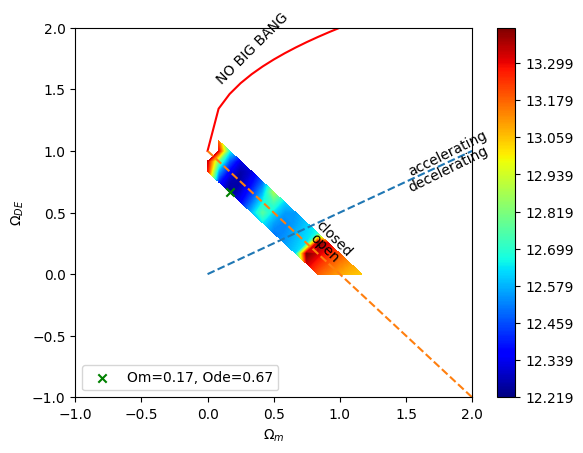

In [4]:
sumdata = np.zeros([len(Om), len(Ode)])
for i in range(len(Om)):
    for j in range(len(Ode)):
        sumdata[i, j] = np.sum(data[i, j, :])

# Create a proper mask for unphysical regions
# instead of a simple mask, the proper mask ensures that values aren't marked as NaN or 0, important for the argmin results
mask = np.zeros_like(sumdata, dtype=bool)
for i in range(len(Om)):
    for j in range(len(Ode)):
        if (Om[i]+Ode[j]>1.2 or # approx flat-universe region
                Om[i]+Ode[j]<0.8 or
                Ode[j] >= Om[i]** (1/2.32) + 1.0 or # approx no big bang area
                not np.isfinite(sumdata[i, j])):
            mask[i,j]=True

masked_sumdata = np.ma.masked_where(mask, sumdata)

#best_fit = np.argmin(masked_sumdata)
#Om_index, Ode_index = np.unravel_index(best_fit, masked_sumdata.shape)
#Om_fit, Ode_fit = Om[Om_index], Ode[Ode_index]

# find minimum among valid entries
valid_indices = np.where(~mask)
valid_values = sumdata[valid_indices]
bestfit = np.argmin(valid_values)
Om_index = valid_indices[0][bestfit]
Ode_index = valid_indices[1][bestfit]
Om_fit, Ode_fit = Om[Om_index], Ode[Ode_index]

print(f'Best fit: Om={Om_fit:.3f}, Ode={Ode_fit:.3f}')
print(f'Sum of distances: {sumdata[Om_index,Ode_index]:.3}')


# Plot
plt.figure()
plt.contourf(Om, Ode, masked_sumdata.T, cmap='jet', levels=1000)
#plt.contour(Om, Ode, masked_sumdata.T, cmap='plasma', levels=10)
plt.colorbar()
plt.scatter(Om_fit, Ode_fit, c='g', marker='x', label=f'Om={Om_fit:.2f}, Ode={Ode_fit:.2f}')
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_{DE}$')

plt.plot(Om, 0.5*Om, linestyle='--')
plt.annotate('accelerating',(1.5,0.80), rotation=26.35)
plt.annotate('decelerating',(1.5,0.67), rotation=26.35)

plt.plot(Om, Om**(1/2.32)+1, c='r')
plt.annotate('NO BIG BANG',(0.05,1.55),rotation=45)

plt.plot(Om, 1-Om, linestyle='--')
plt.annotate('open',(0.75,0.1),rotation=-45)
plt.annotate('closed',(0.8,0.15),rotation=-45)

plt.legend()
plt.xlim(-1.0,2.0)
plt.ylim(-1.0,2.0)

In [ ]:
plt.figure()
plt.contourf(Om, Ode, masked_sumdata.T, cmap='jet', levels=100)
plt.colorbar()
plt.scatter(Om_fit, Ode_fit, c='r', marker='x')
plt.xlim(0.1,0.4)
plt.ylim(0.5,0.9)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_{DE}$')

In [ ]:
z_plot = np.linspace(0.,5.,100)

fig, ax = plt.subplots(2,1)
ax[0].plot(z_plot, luminosity_distance(z_plot), label=f'standard cosmology', color='grey', linestyle='--')
ax[0].plot(z_plot, luminosity_distance(z_plot, O_m=Om_fit, O_DE=Ode_fit), label=f'Epeak-Eiso best fit: {Om_fit:.4f}, {Ode_fit:.4f}, {(1.0-Om_fit-Ode_fit):.4f}')
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$D_L$')

ax[1].contour(Om, Ode, masked_sumdata.T, cmap='jet', levels=50)
ax[1].scatter(Om_fit, Ode_fit, c='r', marker='x')
# ax[1] add sth for comparison
ax[1].set_xlabel(r'$\Omega_m$')
ax[1].set_ylabel(r'$\Omega_{DE}$')

---
The same but with more resolution.

In [ ]:
# Define cosmological parameter grids
Om = np.linspace(0.0,1.0,75)  # parameters are ±0.1 of the 'standard cosmology'
Ode = np.linspace(0.0,1.0,75)
k = np.linspace(-25.,-20.,25) # from the previous scatter plot, we can infer that the y-axis cut is around -25 and -20
m = np.linspace(0.0,1.0,25) # the slope must be positive

data = np.zeros([len(Om), len(Ode), len(df['Eiso'])])
fig, ax = plt.subplots(len(Om), len(Ode), figsize=(15,15))
for i in range(len(Om)):
    for j in range(len(Ode)):
        isotropic_model = isotropic_equivalent_energy(z,S,H0_cgs,Om[i],Ode[j])

        G = np.zeros([len(m), len(k)]) # G[i,j] corresponds to m[i], k[j]
        for mu in range(len(m)):
            for nu in range(len(k)):
                G[mu,nu] = GoF(m[mu], k[nu], x=isotropic_model, y=Epeak)

        # extract best fit parameters
        best_fit = np.argmin(G)
        m_index, k_index = np.unravel_index(best_fit, G.shape)
        m_fit, k_fit = m[m_index], k[k_index]
        data[i,j,:] = measure_distances(m_fit, k_fit, isotropic_model, Epeak)
        print(i,j,m_fit, k_fit)
        ax[i, j].scatter(isotropic_model, Epeak, s=1)
        ax[i, j].plot(isotropic_model, m_fit * isotropic_model + k_fit, c='r')


np.save(f'4x{len(Om)}_distances.npy', data)

In [ ]:
d = np.load('4x50_distances.npy')

sumdata = np.zeros([len(Om), len(Ode)])
for i in range(len(Om)):
    for j in range(len(Ode)):
        sumdata[i, j] = np.sum(d[i, j, :])

# Create a mask for the region where Om + Ode > 1
mask = np.zeros_like(sumdata, dtype=bool)
mask_bool = True
for i in range(len(Om)):
    for j in range(len(Ode)):
        if Om[i] + Ode[j] > 1.1:
            mask[i, j] = mask_bool
        elif Om[i] + Ode[j] < 0.9:
            mask[i, j] = mask_bool

masked_sumdata = np.ma.masked_where(mask, sumdata)

# Plot
plt.figure()
plt.contourf(Om, Ode, np.log10(masked_sumdata.T), cmap='jet', levels=1000)
plt.colorbar()
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_{DE}$')
plt.figure()
plt.contourf(Om, Ode, masked_sumdata.T, cmap='jet', levels=100)
plt.colorbar()
plt.xlim(0.1, 0.4)
plt.ylim(0.5, 0.9)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_{DE}$')
best_fit = np.argmin(masked_sumdata)
Om_index, Ode_index = np.unravel_index(best_fit, masked_sumdata.shape)
Om_fit, Ode_fit = Om[Om_index], Ode[Ode_index]

z_plot = np.linspace(0., 5., 100)
plt.figure()
plt.plot(z_plot, luminosity_distance(z_plot), label=f'standard cosmology', color='grey', linestyle='--')
plt.plot(z_plot, luminosity_distance(z_plot, O_m=Om_fit, O_DE=Ode_fit),
         label=f'Epeak-Eiso best fit: {Om_fit:.4f}, {Ode_fit:.4f}')

plt.legend()
plt.tight_layout()
plt.xlabel(r'$z$')
plt.ylabel(r'$D_L$')